In [13]:
#THIS CODE WAS MADE BY JHERSON CUEVA (for more details, you can contact to jherson.cueva@pucp.edu.pe)
import pandas as pd
import requests

class bcrp_data:
    def __init__(self, start_date, end_date, tickers, frequency):
        self.url_base = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/'
        self.tickers = tickers
        self.frequency = frequency.lower()
        self.period = self._generate_period(start_date, end_date)
        self.month_s = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']
        self.month_d = ['01','02','03','04','05','06','07','08','09','10','11','12']
        self.quarter_s = ['T1','T2','T3','T4']
        self.quarter_d = ['03','06','09','12']

    def _generate_period(self, start_date, end_date):
        if self.frequency == 'yearly':
            return f"/{start_date}/{end_date}"
        elif self.frequency == 'quarterly':
            return f"/{start_date}-T1/{end_date}-T4"
        elif self.frequency == 'monthly':
            return f"/{start_date}/{end_date}"
        elif self.frequency == 'daily':
            return f"/{start_date}/{end_date}"
        else:
            raise ValueError("Unsupported frequency. Choose from: 'yearly', 'quarterly', 'monthly', 'daily'.")

    def fetch_data(self):
        df_combined = pd.DataFrame()

        for ticker in self.tickers:
            url = f"{self.url_base}{ticker}/json{self.period}"
            response = requests.get(url)
            data = response.json()
            periods = data['periods']

            dates, values = [], []
            for period in periods:
                aux_date = period['name']
                aux_value = period['values']

                dates.append(aux_date)
                if aux_value[0] != 'n.d.':
                    values.append(float(aux_value[0]))
                else:
                    values.append(0)

            df_aux = pd.DataFrame({
                'Fecha': dates,
                data['config']['series'][0]['name']: values
            })

            df_aux = self._process_dates(df_aux)
            df_combined = pd.concat([df_combined, df_aux], axis=1)

        return df_combined

    def _process_dates(self, df):
        if self.frequency == 'yearly':
            df['Fecha'] = [f"{date}-12-31" for date in df['Fecha']]
            df['Fecha'] = pd.to_datetime(df['Fecha']) + pd.offsets.MonthEnd(0)
            df['Fecha'] = df['Fecha'].dt.to_period('Y')

        elif self.frequency == 'quarterly':
            for s, d in zip(self.quarter_s, self.quarter_d):
                df['Fecha'] = df['Fecha'].str.replace(s, f"{d}-01")

            df['Fecha'] = df['Fecha'].str.replace('.', '-')
            df['Fecha'] = pd.to_datetime(df['Fecha']) + pd.offsets.MonthEnd(0)
            df['Fecha'] = df['Fecha'].dt.to_period('Q')

        elif self.frequency == 'monthly':
            for s, d in zip(self.month_s, self.month_d):
                df['Fecha'] = df['Fecha'].str.replace(s, d)

            df['Fecha'] = df['Fecha'].str.replace('.', '-')
            df['Fecha'] = pd.to_datetime(df['Fecha']) + pd.offsets.MonthEnd(0)
            df['Fecha'] = df['Fecha'].dt.to_period('M')

        elif self.frequency == 'daily':
            for s, d in zip(self.month_s, self.month_d):
                df['Fecha'] = df['Fecha'].str.replace(s, d)

            df['Fecha'] = df['Fecha'].str.replace('.', '-')
            df['Fecha'] = pd.to_datetime(df['Fecha'])

        df.set_index('Fecha', inplace=True)
        return df

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.stats import invwishart, percentileofscore
import time

In [ ]:
data = bcrp_data(start_date="2004-01",end_date="2025-06",tickers=['PN01273PM','PN01728AM','PD04722MM','PN38926BM','PN01216PM','PN01277PM','PN01652XM','PN01660XM','PD12912AM','PN00539MM'],frequency="monthly")
data = data.fetch_data()
data.head(3)


In [23]:
data.columns =  ["IPC","GDP","TPM","TOT","E","IPC_SAE","COBRE","OIL",'E_IPC','CRED']

In [26]:
data.to_excel("data_pe/data_peru.xlsx",index=True)

### Forecast for annual GDP growth and inflation using a VAR with a Minnesota prior

In [ ]:
'PN01273PM','PN01728AM','PD04722MM','PN38926BM','PN01216PM','PN01277PM','PN01652XM','PN01660XM','PD12912AM','PN00539MM'

 IPC 	 GDP 	 Tasa_Ref 	 ToT 	 Deprec_Nom_12M 	 IPC_sae 	 Cobre 	 Petroleo_WTI   exp_inflacion   cred_sector_privado



# PN01277PM	sae
# PN09819PM   ae
# PN38923BM - niveles

# PN01649XM   Harina de Pescado - Hamburgo (US$ por toneladas)	 
# PN01652XM   Cobre - LME (¢US$ por libras)	

# PN01660XM   Petróleo - WTI (US$ por barriles)	
# PN01661XM   Trigo - EEUU (US$ por toneladas)	
# PN01662XM   Maíz - EEUU (US$ por toneladas)


# PN31883GM	Ingresos promedio del sector formal total nominal (S/)	
# PN31884GM	Ingresos promedio del sector formal total nominal (var.% 12 meses)	
# PN31885GM	Masa salarial del sector formal total nominal (millones S/)	
# PN31886GM	Masa salarial del sector formal total nominal (var.% 12 meses)



# Crédito al sector privado de las sociedades creadoras de depósito, por tipo de crédito - (8 series)
# 	PN00532MM	Saldos - A Empresas (millones S/)	
# 	PN00539MM	Tasas de Crecimiento Anual (%)

# PD12912AM	Expectativa de Inflación a 12 meses	
# PD38048AM	Expectativa de PBI a 12 meses	
# PD38049AM	Expectativa de TC a 12 meses

In [12]:
df = pd.read_excel("data_pe/datos.xlsx", sheet_name="Hoja2", usecols="B:J", nrows=252)
columnas = ["IPC", "GDP", "Tasa_Ref", "ToT", "Deprec_Nom_12M", "IPC_sae", "TPU_g", "Cobre", "Petroleo_WTI"]
df.columns = columnas

date = pd.date_range(start="2004-01-31", periods=252, freq="M")
df.index = date

C:\Users\jhers\AppData\Local\Temp\ipykernel_24096\2863841439.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date = pd.date_range(start="2004-01-31", periods=252, freq="M")


In [10]:
df

,IPC,GDP,Tasa_Ref,ToT,Deprec_Nom_12M,IPC_sae,TPU_g,Cobre,Petroleo_WTI
2004-01-31,2.758266,3.609049,2.50,10.477751,0.565803,0.675626,-0.206323,38.431348,3.794433
2004-02-29,3.370766,4.158291,2.50,15.698761,-0.189857,0.786403,0.057446,49.215550,-3.221321
2004-03-31,2.718578,5.613699,2.50,26.320829,-0.389392,0.928552,-0.456721,59.448692,9.444295
2004-04-30,2.746676,4.160245,2.50,26.392203,0.647922,0.899373,-0.369023,61.074926,26.318181
2004-05-31,3.131926,3.874711,2.50,18.417245,-0.252091,1.058373,-0.199070,50.611873,35.699209
...,...,...,...,...,...,...,...,...,...
2024-08-31,2.013686,3.685904,5.50,12.347746,1.359761,2.912686,2.026437,7.110508,-5.952192
2024-09-30,1.759441,3.234038,5.25,13.834751,-2.315264,2.702113,2.548988,16.493931,-23.601031
2024-10-31,1.989263,3.580420,5.25,16.280926,-1.825502,2.481972,2.818730,18.354339,-16.970846
2024-11-30,2.246565,4.063914,5.00,11.844677,0.168470,2.516750,4.606179,10.781365,-10.369838


C:\Users\jhers\AppData\Local\Temp\ipykernel_24096\954799955.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


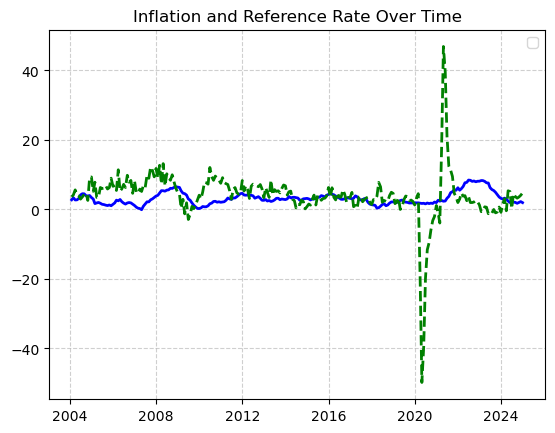

In [11]:
# Rate and Inflation
data = df[["IPC", "GDP"]].copy()
N = data.shape[1]
L = 3
Y = data.values

plt.plot(df.index, df["IPC"], color="blue", linewidth=2)
# plt.plot(df.index, df["Tasa_Ref"], color="red", linestyle="dashed", linewidth=2)
plt.plot(df.index, df["GDP"], color="green", linestyle="dashed", linewidth=2)
plt.title("Inflation and Reference Rate Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [69]:
N = data.shape[1]
L = 2  # Number of lags in the VAR
Y = data.values

# Create lagged variables
X = np.column_stack((np.ones((Y.shape[0], 1)), np.roll(Y, 1, axis=0), np.roll(Y, 2, axis=0)))
Y = Y[2:]
X = X[2:]
T = X.shape[0]

In [70]:
# Compute standard deviation of each series' residual via an OLS regression
# First variable
y = Y[:, 0]
x = X[:, [0, 1]]
b0 = np.linalg.solve(x.T @ x, x.T @ y)
s1 = np.sqrt(((y - x @ b0) @ (y - x @ b0)) / (y.shape[0] - 2))

In [71]:
# Second variable
y = Y[:, 1]
x = X[:, [0, 2]]
b0 = np.linalg.inv(x.T @ x) @ x.T @ y
#b0 = np.linalg.solve(x.T @ x, x.T @ y)
s2 = np.sqrt(((y - x @ b0) @ (y - x @ b0)) / (y.shape[0] - 2))
s1,s2

(0.39722855932771073, 4.251427796648808)

In [109]:
# Specify parameters of the Minnesota prior
lamda1 = 1  # Controls the prior on own lags
lamda2 = 1
lamda3 = 1
lamda4 = 1

# Specify the prior mean of the coefficients of the two equations of the VAR
B01 = np.array([0, 1, 0, 0, 0])
B02 = np.array([0, 0, 1, 0, 0])

B0 = np.concatenate((B01, B02))

In [110]:
# Specify the prior variance of vec(B)
H = np.zeros((10, 10))
# For equation 1 of the VAR
H[0, 0] = (s1 * lamda4) ** 2  # Constant
H[1, 1] = (lamda1) ** 2  # Own lag
H[2, 2] = ((s1 * lamda1 * lamda2) / s2) ** 2  # Lag of the other variable
H[3, 3] = (lamda1 / (2 ** lamda3)) ** 2  # Own second lag
H[4, 4] = ((s1 * lamda1 * lamda2) / (s2 * (2 ** lamda3))) ** 2  # Lag of the other variable
# For equation 2 of the VAR
H[5, 5] = (s2 * lamda4) ** 2  # Constant
H[6, 6] = ((s2 * lamda1 * lamda2) / s1) ** 2  # Lag of the other variable
H[7, 7] = (lamda1) ** 2  # Own lag
H[8, 8] = ((s2 * lamda1 * lamda2) / (s1 * (2 ** lamda3))) ** 2  # Lag of the other variable
H[9, 9] = (lamda1 / (2 ** lamda3)) ** 2  # Own second lag

In [111]:
def vec(y):
    x = np.array([]) 
    
    for i in range(1,y.shape[1]):
        x = np.vstack([x, y[:, i-1]])  
    
    return x


In [112]:
# Prior scale matrix for sigma, the VAR covariance
S = np.eye(N)
# Prior degrees of freedom
alpha = N + 1

# Starting values for the Gibbs sampling algorithm
Sigma = np.eye(N)
beta_ols = (np.linalg.inv(X.T@X))@(X.T@Y)
beta_ols = beta_ols.T.flatten()
beta_ols

array([ 5.78588179e-02,  1.26661481e+00, -5.67261149e-05, -2.99472561e-01,
        1.01739295e-02,  1.42883366e+00,  9.51630122e-01,  1.05986553e+00,
       -1.04400587e+00, -3.34009057e-01])

In [113]:
Reps = 10000
burn = 5000

In [114]:
def IWPQ(v, ixpx):
    k = ixpx.shape[0]
    z = np.zeros((v, k))
    mu = np.zeros((k, 1))

    for i in range(1,v):
        chol_ixpx = cholesky(ixpx,lower=False)#,lower=False)  #, lower=True)
        z[i, :] = (chol_ixpx.T @ np.random.randn(k, 1)).T

    out = np.linalg.inv(z.T @ z)
    return out

In [115]:
t = 0
start = time.time()

i=1
for j in range(1, Reps + 1):

    # Step 1: Draw the VAR coefficients
    M1 = np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma), X.T @ X)
    M2 = np.linalg.inv(H) @ B0 + np.kron(np.linalg.inv(Sigma), X.T @ X) @ beta_ols
    M = np.linalg.solve(M1, M2)
    V = np.linalg.inv(M1)

    beta = M + np.random.randn(N * (N * L + 1)) @ cholesky(V, lower=False)


    # Step 2: Draw Sigma from the Inverted Wishart distribution
    e = Y - X @ beta.reshape(N,(N * L + 1)).T

    scale = e.T @ e + S
    Sigma = IWPQ(T + alpha, np.linalg.inv(scale))
    
    
    if j > burn:
        
        # Forecast Rate and inflation for 2 years
        yhat = np.zeros((14, 2))
        yhat[0:2, :] = Y[-2:, :]

        for i in range(2, 14):
            lag_val = np.concatenate([np.array([1]), yhat[i - 1, :], yhat[i - 2, :]])
            yhat[i, :] = lag_val@ (beta.reshape(N,N * L + 1)).T + np.random.randn(1, N) @ np.linalg.cholesky(Sigma)

        if j == burn + 1:
            out1 = np.hstack((Y[:, 0], yhat[2:, 0]))
            out2 = np.hstack((Y[:, 1], yhat[2:, 1]))
        else:
            out1 = np.c_[out1,np.hstack((Y[:, 0], yhat[2:, 0]))]
            out2 = np.c_[out2,np.hstack((Y[:, 1], yhat[2:, 1]))]    
    
        
    if (j + 1) % 1000 == 0:
        end = time.time()
        elapsed = end - start
        t += elapsed
        print(f"Iteración {j + 1}, tiempo acumulado: {t} s")
    #start_time= time.time()


Iteración 1000, tiempo acumulado: 3.898388385772705 s
Iteración 2000, tiempo acumulado: 11.669012069702148 s
Iteración 3000, tiempo acumulado: 23.3173611164093 s
Iteración 4000, tiempo acumulado: 38.93675351142883 s
Iteración 5000, tiempo acumulado: 58.504417181015015 s
Iteración 6000, tiempo acumulado: 82.95140361785889 s
Iteración 7000, tiempo acumulado: 126.21767520904541 s
Iteración 8000, tiempo acumulado: 178.17157196998596 s
Iteración 9000, tiempo acumulado: 240.89996337890625 s
Iteración 10000, tiempo acumulado: 318.2237067222595 s


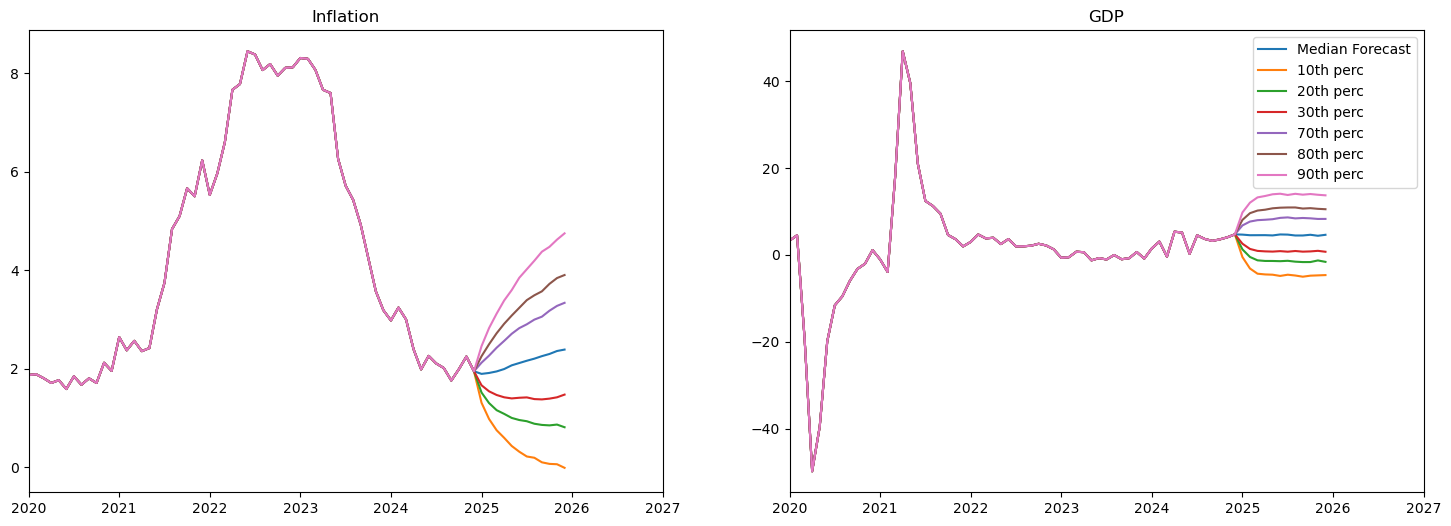

In [120]:
fig = plt.figure(figsize=(18, 6))

TT = np.arange(2004 + 2/12, 2025+ 12/12, 1/12)


plt.subplot(1, 2, 1)
percentiles = np.percentile(out1, [50, 10, 20, 30, 70, 80, 90], axis=1)
plt.plot(TT, percentiles.T)
plt.xlim([2020, 2027])
plt.title('Inflation')

plt.subplot(1, 2, 2)
percentiles = np.percentile(out2, [50, 10, 20, 30, 70, 80, 90], axis=1)
plt.plot(TT, percentiles.T)
plt.xlim([2020, 2027])
plt.legend(['Median Forecast', '10th perc', '20th perc', '30th perc',
            '70th perc', '80th perc', '90th perc'])
plt.title('GDP')


plt.show()

fig.savefig('forecast_rate_and_inflation.png', dpi=fig.dpi)

In [121]:
percentiles

array([[ 5.6136986 ,  4.16024452,  3.87471092, ...,  4.64432283,
         4.41611878,  4.63742635],
       [ 5.6136986 ,  4.16024452,  3.87471092, ..., -4.77423094,
        -4.69833415, -4.64070204],
       [ 5.6136986 ,  4.16024452,  3.87471092, ..., -1.63765326,
        -1.26902813, -1.59469326],
       ...,
       [ 5.6136986 ,  4.16024452,  3.87471092, ...,  8.42961657,
         8.28695021,  8.29484234],
       [ 5.6136986 ,  4.16024452,  3.87471092, ..., 10.77199645,
        10.61801371, 10.52858197],
       [ 5.6136986 ,  4.16024452,  3.87471092, ..., 14.02836154,
        13.85553311, 13.72742499]])

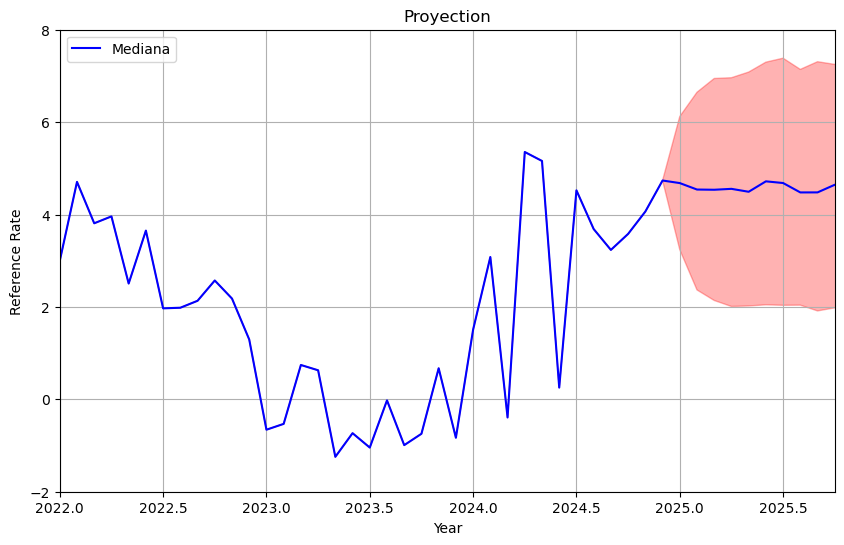

In [129]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)
percentiles = np.percentile(out2.T, [36, 50, 64], axis=0)


fig, ax = plt.subplots(figsize=(10, 6))

# for i, alpha in enumerate([0.1, 0.2, 0.3]):
ax.fill_between(TT, percentiles[0], percentiles[2], color='red', alpha=0.3)

ax.plot(TT, percentiles[1], color='blue', label='Mediana')

ax.set_xlim([2022, 2025.75])
ax.set_ylim([-2, 8])
ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Reference Rate')
ax.legend()
ax.grid(True)

plt.show()

In [100]:
percentiles[1]

array([ 5.61369860e+00,  4.16024452e+00,  3.87471092e+00,  2.96557160e+00,
        3.59553508e+00,  4.35405525e+00,  4.67428042e+00,  2.58683120e+00,
        9.03631626e+00,  9.34391582e+00,  5.21746505e+00,  7.83250440e+00,
        3.45084249e+00,  3.48111461e+00,  6.30583460e+00,  6.02047012e+00,
        6.10621470e+00,  6.82472889e+00,  5.87699246e+00,  6.29059262e+00,
        8.98397662e+00,  6.65680258e+00,  6.86086797e+00,  5.45653777e+00,
        1.14038257e+01,  5.26206621e+00,  5.92100438e+00,  7.21412768e+00,
        6.31041131e+00,  9.82234027e+00,  7.82509863e+00,  8.34394616e+00,
        4.63408128e+00,  8.24960150e+00,  4.89076482e+00,  4.66288600e+00,
        5.84655769e+00,  5.15830385e+00,  6.90098573e+00,  6.29938632e+00,
        9.81165785e+00,  8.95187503e+00,  1.21530304e+01,  1.12430015e+01,
        9.37123509e+00,  1.17866404e+01,  9.09008787e+00,  1.27013528e+01,
        7.34018791e+00,  1.31768366e+01,  6.77155978e+00,  1.02466352e+01,
        9.08807183e+00,  

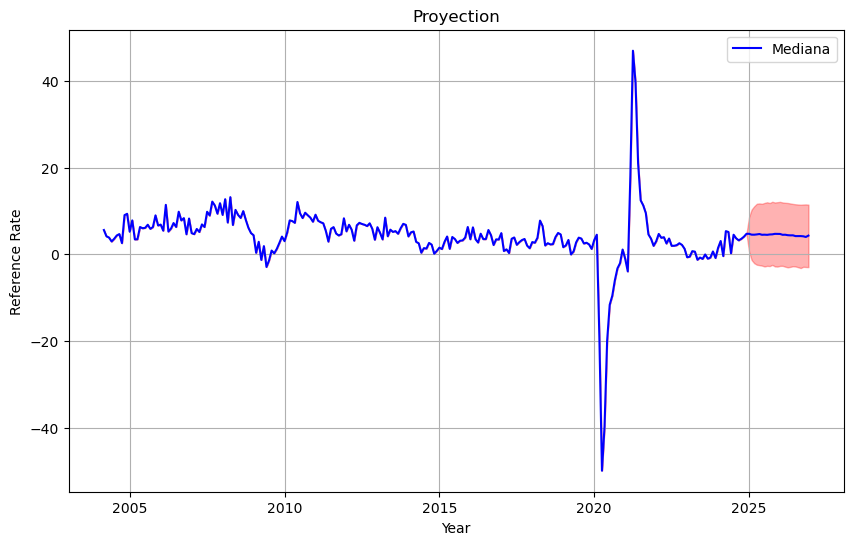

In [ ]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

for i, alpha in enumerate([0.1, 0.2, 0.3]):
    ax.fill_between(TT, percentiles[i], percentiles[6-i], color='red', alpha=alpha)

ax.plot(TT, percentiles[3], color='blue', label='Mediana')

# ax.set_xlim([2010, 2026.75])
ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Reference Rate')
ax.legend()
ax.grid(True)

plt.show()

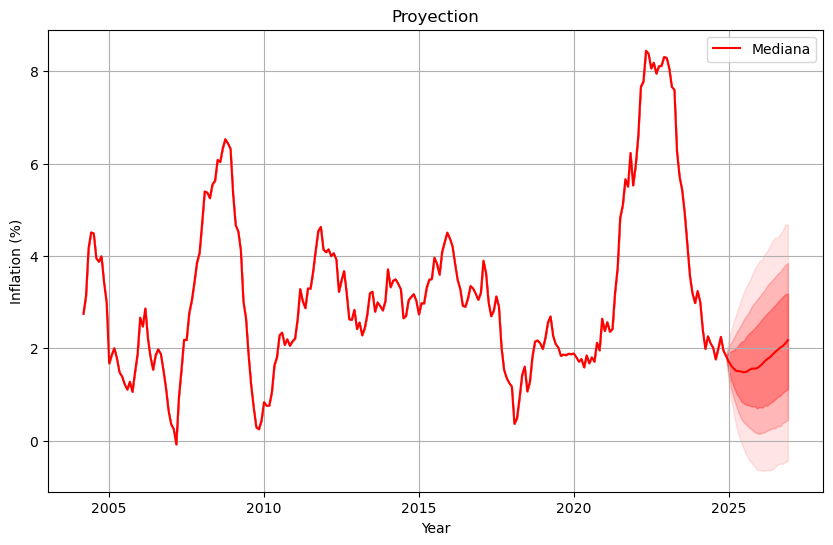

In [302]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

# bandas de confianza como mapas de calor
for i, alpha in enumerate([0.1, 0.2, 0.3]):
    ax.fill_between(TT, percentiles[i], percentiles[6-i], color='red', alpha=alpha)

ax.plot(TT, percentiles[3], color='red', label='Mediana')

# ax.set_xlim([2010, 2026.75])
ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation (%)')
ax.legend()
ax.grid(True)

plt.show()

In [304]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig = go.Figure()

colors = ["rgba(255, 0, 0, 0.1)", "rgba(255, 0, 0, 0.2)", "rgba(255, 0, 0, 0.3)"]
for i in range(3):
    fig.add_trace(go.Scatter(
        x=TT, y=percentiles[6 - i], mode="lines", line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=TT, y=percentiles[i], mode="lines", fill="tonexty",
        fillcolor=colors[i], line=dict(width=0), showlegend=False
    ))


fig.add_trace(go.Scatter(
    x=TT, y=percentiles[3], mode="lines",
    line=dict(color="red", width=2), name="Median"
))


fig.update_layout(
    title="Inflation",
    xaxis_title=None,
    yaxis_title="(%)",
    template="plotly_white",
    hovermode="x",
    xaxis=dict(range=[2010, 2027]),
    yaxis=dict(gridcolor="lightgray"),
    width=1000,  
    height=600,  
)


fig.show()
